In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import main
import preprocess_functions
import os
import time
import pickle
from astropy.io import fits
from matplotlib.colors import LogNorm
import h5py

In [7]:
# HI4PI
CRPIX3_hi4pi= 466
CDELT3_hi4pi = 1288.21496


def chan2velo(channel, CRPIX3 = CRPIX3_hi4pi, CDELT3 = CDELT3_hi4pi):
    """
    Convert Channel to LSR velocity in m/s
    """
    return (channel - CRPIX3) * CDELT3


# h5py different organization to keep storage low

In [5]:
def make_hdf5(clouds_per_sq_deg, nside_low = 128, \
                     pixindex_start = 0, pixindex_fin = hp.nside2npix(128),\
                    Ngauscut = 20):
    
    # arrays of clouds properties
    
    centroids = np.array([])
    stds = np.array([])
    nhs = np.array([])
    Nmaxs = np.array([])
    Ngaus = np.array([])
    hpxpixids = np.array([])
    
    # there is a set of bad pixels in the HI4PI data at this location. do not count these pixels
    mask_l,mask_b = 208.98, -19.35
    vec  = hp.ang2vec(mask_l, mask_b, lonlat=True)
    badpixels = hp.query_disc(nside_low, vec, np.radians(0.25), inclusive = True, nest = True )

    # Keep track of progress
    print 'Total of', len(clouds_per_sq_deg.keys())
    
    cc = 0
    
    # Loop over superpixels
    for kk,pixid in enumerate(clouds_per_sq_deg.keys()):
        
        # skip the pixels up to pixindex_start and from pixindex_fin onwards
        if kk < pixindex_start:
            continue
        elif kk > pixindex_fin:
            continue
        else:
            pass
        
        # Keep track of progress
        print '{0}\r'.format(kk),
         
        
        # skip the bad pixels in the dataset
        if pixid in badpixels:
            continue
        
        
        try:
            clouds = clouds_per_sq_deg[pixid]['clouds']
        except:
            clouds = clouds_per_sq_deg[pixid]
            
        
        
        for cloud in clouds:
            
            nh = 1.823*1e18*cloud['line_integral_kmsK'].sum()/len(np.unique(cloud['hpxind']))
            
            # if centroid is not calculated, do that now
            if cloud['centroid']!=cloud['centroid']:
                # Create array of channels for computing the cloud spectrum later on.
                # Since max sigma of gaussians is ~14 channels, safe to evaluate spectrum in this range:
                # this is just for calculating centroid, not the column density
                chans = np.arange(cloud['means'].min()-40,cloud['means'].max()+40)
                
                # Compute vel centroid and skewness of each cloud spectrum - takes time
                # Create an array with spectra from each gaussian in the cloud
                gaussian_array = main.gaus( np.reshape(cloud['means'],(1,len(cloud['means']))).T, \
                               np.reshape(cloud['sigmas'],(1,len(cloud['means']))).T, \
                               np.reshape(cloud['amps'],(1,len(cloud['means']))).T, \
                               chans)
                # Compute the mean spectrum (sum signal over all Gaussians)
                meanspec = np.average(gaussian_array, axis = 0).T
                # Get the centroid velocity (expectation value) of the mean spectrum
                mean_of_spec = np.sum(meanspec*chans)/np.sum(meanspec)
                # Get the peak velocity
                peakvel = chans[np.argmax(meanspec)]
                # Count number of maxima in the cloud spectrum
                maxs = main.get_min_max_der(chans,meanspec)[1]
                # Compute measure of skewness of the spectrum: difference between cenroid and peak
                skew = mean_of_spec-peakvel
                # Get variance (second moment) of cloud spectrum
                var = np.sum(meanspec*(chans - mean_of_spec)**2)/np.sum(meanspec)

                    
                cloud['centroid'] = mean_of_spec
                cloud['skew'] = skew
                cloud['nmaxima'] = chans[maxs].shape[0]
                cloud['std'] = np.sqrt(var)
                    
            hpxpixids = np.append(hpxpixids, pixid)
            centroids = np.append(centroids, chan2velo(cloud['centroid'])/1.e3) # velocity centroid (in channels)
            Nmaxs = np.append(Nmaxs,cloud['nmaxima']) # number of maxima in the cloud spectrum
            stds = np.append(stds,cloud['std']*CDELT3_hi4pi/1.e3) # Standard deviation of cloud spectrum
            nhs = np.append(nhs,nh)
            Ngaus = np.append(Ngaus,len(cloud['means']))
            
            
            
            cc+=1
        
    return hpxpixids, centroids, stds, Nmaxs, nhs, Ngaus

In [10]:
def make_fits(array, savename, **kwargs):
    hp.write_map("%s.fits"%savename, array, overwrite=True, **kwargs)
    return

# BICEP

In [4]:
bw= 4

savedir = 'BICEP/'

fop = open(savedir+'clouds_per_sqdeg_btw_%d_full.pickle'%bw)
clouds_per_sq_deg = pickle.load(fop)

In [8]:
Nside_low = 128

hpxpixids, centroids, stds, Nmaxs, nhs, Ngaus = make_hdf5(clouds_per_sq_deg, nside_low = Nside_low, \
                     pixindex_start = 0, pixindex_fin = hp.nside2npix(Nside_low),\
                    Ngauscut = 20)

Total of 4577


In [9]:
f = h5py.File(pubdatadir+'clouds_db.hdf5', 'w')#'a'

grp = f.create_group('clouds')

f['clouds'].create_dataset('hpxpix', data= hpxpixids)
f['clouds'].create_dataset('centroids', data= centroids)
f['clouds'].create_dataset('std', data= stds)
f['clouds'].create_dataset('Nmaxima', data= Nmaxs)
f['clouds'].create_dataset('cloudNH', data= nhs)
f['clouds'].create_dataset('Ngaussians', data= Ngaus)

f['clouds'].attrs.create('Nside', 128)
f['clouds'].attrs.create('NEST', True)

print f.attrs

def printname(name):
    print(name)
    
f.visit(printname)

f.close()

<Attributes of HDF5 object at 139669940440528>
clouds
clouds/Ngaussians
clouds/Nmaxima
clouds/centroids
clouds/cloudNH
clouds/hpxpix
clouds/std


# Write individual maps in healpix fits format

In [59]:
bw= 4

savedir = 'BICEP/'
pubdatadir = 'PublicData/BICEP/'

Ngauscut = 20

NHcut = 0

cname = 'noHVC_Ngauscut%d_bw_%d_NHcut%d'%(Ngauscut,bw,NHcut/1e19)

# Map of column-density-weighted Nc
Neff_map_lowres_noHVC=np.load(savedir+'Neff_map_lowres_'+cname+'.npy')
# Map of NHI
NH_map_lowres_noHVC=np.load(savedir+'NH_map_lowres_'+cname+'.npy')
# Map of Nc
Nclouds_map_lowres_noHVC = np.load(savedir+'Nclouds_map_lowres_'+cname+'.npy')
# Map of IVC NH
NH_map_lowres_IVC = np.load(savedir+'NH_map_lowres_IVC_Ngauscut20_bw_4_NHcut0.npy')
# Map of LVC NH
NH_map_lowres_LVC = np.load(savedir+'NH_map_lowres_LVC_Ngauscut20_bw_4_NHcut0.npy')


make_fits(Neff_map_lowres_noHVC,pubdatadir+'Nc_weighted',nest=True,partial=True)
make_fits(NH_map_lowres_noHVC,pubdatadir+'NH_clouds',nest=True,partial=True)
make_fits(Nclouds_map_lowres_noHVC,pubdatadir+'Nclouds',nest=True,partial=True)
make_fits(NH_map_lowres_IVC,pubdatadir+'NH_IVC',nest=True,partial=True)
make_fits(NH_map_lowres_LVC,pubdatadir+'NH_LVC',nest=True,partial=True)


In [60]:
hp.write_map(pubdatadir+'NHI_cloud_maps.fits',[NH_map_lowres_noHVC,NH_map_lowres_LVC,NH_map_lowres_IVC],\
             column_names = ['NHI_clouds','NHI_IVC','NHI_LVC'],\
             column_units = ['cm^-2','cm^-2','cm^-2'], coord='G',nest=True, partial=True, overwrite=True)

hp.write_map(pubdatadir+'Ncloud_maps.fits',[Nclouds_map_lowres_noHVC,Neff_map_lowres_noHVC],\
             column_names = ['Nclouds','Nc'],\
             column_units = ['number of clouds','column-density-weighted number of clouds'], coord='G',nest=True, partial=True, overwrite=True)

In [24]:
from astropy.io import fits

In [49]:
hdulist = fits.open(pubdatadir+'Ncloud_maps.fits')
print hdulist
hdulist[1].header

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f0770fab210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f076bb3f990>]


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   12 / length of dimension 1                          
NAXIS2  =                 4577 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'PIXEL   '                                                            
TFORM1  = 'J       '                                                            
TTYPE2  = 'Nclouds '                                                            
TFORM2  = 'E       '                                                            
TUNIT2  = 'number of clouds'

# Plot column density of LVCs

In [50]:
nh_LVC = hp.read_map(pubdatadir+'NHI_cloud_maps.fits',field=1)

NSIDE = 128
ORDERING = NESTED in fits file
INDXSCHM = EXPLICIT
Ordering converted to RING


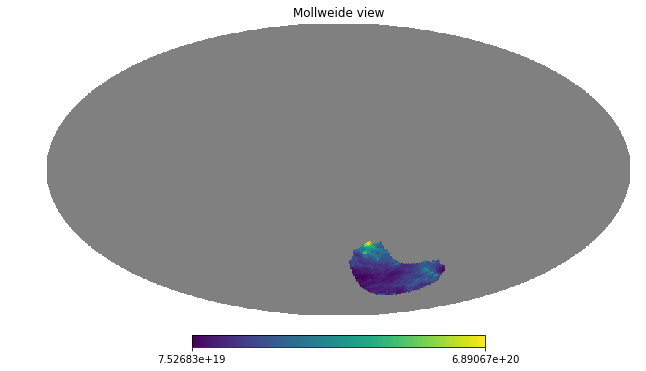

In [51]:
hp.mollview(nh)

# High-lat

## Save fits files of the maps

In [56]:
bw= 4

savedir = 'maskEBV_128/'
pubdatadir = 'PublicData/PolarCaps/'
 

Ngauscut = 20

# Map of column-density-weighted Nc
Neff_map_lowres_noHVC=np.load(savedir+'Neff_map_lowres_noHVC_Ngauscut%d'%Ngauscut+'.npy')
# Map of NHI
NH_map_lowres_noHVC=np.load(savedir+'NH_map_lowres_noHVC_Ngauscut%d'%Ngauscut+'.npy')
# Map of Nc
Nclouds_map_lowres_noHVC = np.load(savedir+'Nclouds_map_lowres_noHVC_Ngauscut%d'%Ngauscut+'.npy')
# Map of IVC NH
NH_map_lowres_IVC = np.load(savedir+'NH_map_lowres_IVC_Ngauscut%d.npy'%Ngauscut)
# Map of LVC NH
NH_map_lowres_LVC = np.load(savedir+'NH_map_lowres_LVC_Ngauscut%d.npy'%Ngauscut)


#make_fits(Neff_map_lowres_noHVC,pubdatadir+'Nc_weighted',nest=True,partial=True)
#make_fits(NH_map_lowres_noHVC,pubdatadir+'NH_clouds',nest=True,partial=True)
#make_fits(Nclouds_map_lowres_noHVC,pubdatadir+'Nclouds',nest=True,partial=True)
#make_fits(NH_map_lowres_IVC,pubdatadir+'NH_IVC',nest=True,partial=True)
#make_fits(NH_map_lowres_LVC,pubdatadir+'NH_LVC',nest=True,partial=True)

In [58]:
hp.write_map(pubdatadir+'NHI_cloud_maps.fits',[NH_map_lowres_noHVC,NH_map_lowres_LVC,NH_map_lowres_IVC],\
             column_names = ['NHI_clouds','NHI_IVC','NHI_LVC'],\
             column_units = ['cm^-2','cm^-2','cm^-2'], coord='G',nest=True, partial=True, overwrite=True)

hp.write_map(pubdatadir+'Ncloud_maps.fits',[Nclouds_map_lowres_noHVC,Neff_map_lowres_noHVC],\
             column_names = ['Nclouds','Nc'],\
             column_units = ['number of clouds','column-density-weighted number of clouds'], coord='G',nest=True, partial=True, overwrite=True)

## Save cloud data in hdf5 file

In [52]:
bw= 4

savedir = 'maskEBV_128/'

fop = open(savedir+'clouds_per_sqdeg_btw_%d_full.pickle'%bw)
clouds_per_sq_deg = pickle.load(fop)

In [83]:
Nside_low = 128

hpxpixids, centroids, stds, Nmaxs, nhs, Ngaus = make_hdf5(clouds_per_sq_deg, nside_low = Nside_low, \
                     pixindex_start = 0, pixindex_fin = hp.nside2npix(Nside_low),\
                    Ngauscut = 20)

Total of 83376


In [85]:
f = h5py.File(savedir+'clouds_db.hdf5', 'w')#'a'

grp = f.create_group('clouds')

f['clouds'].create_dataset('hpxpix', data= hpxpixids)
f['clouds'].create_dataset('centroids', data= centroids)
f['clouds'].create_dataset('std', data= stds)
f['clouds'].create_dataset('Nmaxima', data= Nmaxs)
f['clouds'].create_dataset('cloudNH', data= nhs)
f['clouds'].create_dataset('Ngaussians', data= Ngaus)

f['clouds'].attrs.create('Nside', 128)
f['clouds'].attrs.create('NEST', True)

print f.attrs

def printname(name):
    print(name)
    
f.visit(printname)

f.close()

<Attributes of HDF5 object at 140511175747344>
clouds
clouds/Ngaussians
clouds/Nmaxima
clouds/centroids
clouds/cloudNH
clouds/hpxpix
clouds/std


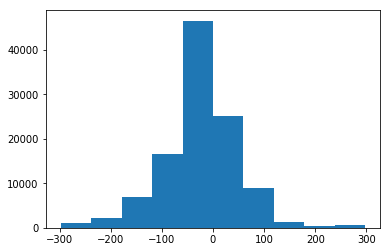

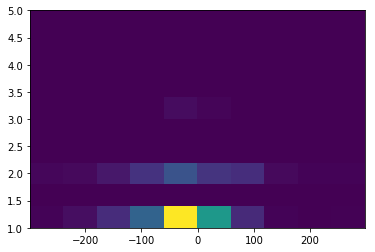

(array([], dtype=int64),)


In [73]:
f = h5py.File(savedir+'clouds_dict.hdf5', 'r')#'a'

cstd = f['clouds']['centroids'][:]
plt.hist(cstd[cstd==cstd])
plt.show()

Ng = f['clouds']['Ngaussians'][:]

Nm = f['clouds']['Nmaxima'][:]

plt.hist2d(cstd,Nm)
plt.show()


print np.where(cstd!=cstd)

f.close()

In [86]:
f = h5py.File(savedir+'clouds_dict.hdf5', 'r')#'a'

In [87]:
# Make Nclouds map
Nside_low = 128

Ncmap = np.zeros(hp.nside2npix(Nside_low))+hp.pixelfunc.UNSEEN

# find unique pixels with cloud info
uniquepix = np.unique(f['clouds']['hpxpix'][:])

# Count number of clouds in each pixel
for ipix in uniquepix:
    
    condition = f['clouds']['hpxpix'][:]==ipix
    N = len(f['clouds']['hpxpix'][:][condition])
    Ncmap[int(ipix)] = N
    

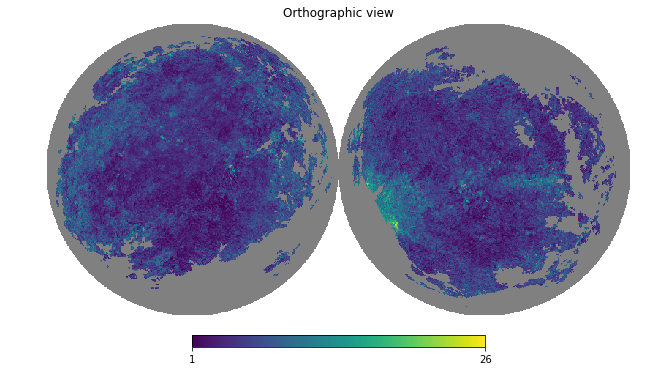

In [88]:
hp.orthview(Ncmap, rot = [0,90], nest=True)

In [89]:
f.close()

# First try at dictionary.. Superseded by hdf5 format

In [2]:
def make_public_dict(clouds_per_sq_deg, nside_low = 128, \
                     pixindex_start = 0, pixindex_fin = hp.nside2npix(128),\
                    Ngauscut = 20):
    # for memory purposes, call this for large ranges of pixels, not all at once
    
    clouddata_small = {}
    
    # there is a set of bad pixels in the HI4PI data at this location. do not count these pixels
    mask_l,mask_b = 208.98, -19.35
    vec  = hp.ang2vec(mask_l, mask_b, lonlat=True)
    badpixels = hp.query_disc(nside_low, vec, np.radians(0.25), inclusive = True, nest = True )

    # Keep track of progress
    print 'Total of', len(clouds_per_sq_deg.keys())
    
    # Loop over superpixels
    for kk,pixid in enumerate(clouds_per_sq_deg.keys()):
        
        # skip the pixels up to pixindex_start and from pixindex_fin onwards
        if kk < pixindex_start:
            continue
        elif kk > pixindex_fin:
            continue
        else:
            pass
        
        # Keep track of progress
        print '{0}\r'.format(kk),
         
        
        # skip the bad pixels in the dataset
        if pixid in badpixels:
            continue
        
        # Store pdf, channels
        clouddata_small[pixid] = {}
        
        clouddata_small[pixid]['clouds'] = []
        
        try:
            clouds = clouds_per_sq_deg[pixid]['clouds']
            clouddata_small[pixid]['pdf'] = clouds_per_sq_deg[pixid]['pdf'] # keep the pixel's pdf - this will be the same for all clouds in pixel pixid
            clouddata_small[pixid]['pdfchans'] = clouds_per_sq_deg[pixid]['pdfchans'] # keep the channels used to make pdf
        except:
            clouds = clouds_per_sq_deg[pixid]
            clouddata_small[pixid]['pdf'] = clouds_per_sq_deg[pixid][0]['pdf'] # keep the pixel's pdf - this will be the same for all clouds in pixel pixid
            clouddata_small[pixid]['pdfchans'] = clouds_per_sq_deg[pixid][0]['pdfchans'] # keep the channels used to make pdf
        
        
        
        for cloud in clouds:
            
            cl = {}
            
            nh = 1.823*1e18*cloud['line_integral_kmsK'].sum()/len(np.unique(cloud['hpxind']))
            
            # Skip the cloud if it does not have enough Gaussians associated with it
            if len(cloud['means']) < Ngauscut:
                cl['centroid'] = np.nan # velocity centroid (in channels)
                #cl['skew'] = np.nan # velocity centroid - peak of spectrum (in channels)
                cl['nmaxima'] = np.nan # number of maxima in the cloud spectrum
                cl['std'] = np.nan # Standard deviation of cloud spectrum
                cl['nh'] = nh
                cl['Ngaus'] = len(cloud['means'])
                continue
                
            else:
                
                cl['centroid'] = cloud['centroid'] # velocity centroid (in channels)
                #cl['skew'] = cloud['skew'] # velocity centroid - peak of spectrum (in channels)
                cl['nmaxima'] = cloud['nmaxima'] # number of maxima in the cloud spectrum
                cl['std'] = cloud['std'] # Standard deviation of cloud spectrum
                cl['nh'] = nh
                cl['Ngaus'] = len(cloud['means'])
            
            clouddata_small[pixid]['clouds'].append(cl)
        
        
    return clouddata_small

## first 1/4th of pixels

In [23]:
s = 0
e = len(clouds_per_sq_deg.keys())/4
print e

clouddata = make_public_dict(clouds_per_sq_deg, nside_low=128, Ngauscut = 20,\
                             pixindex_start = s, pixindex_fin = e)

SFILENAME = 'clouds_dict_1.pickle'
pickle.dump(clouddata, open(savedir+SFILENAME, 'w'))

20844
Total of 83376


In [ ]:
clouddata = make_public_dict(clouds_per_sq_deg, nside_low=128, Ngauscut = 20,\
                             pixindex_start = 0, pixindex_fin = hp.nside2npix(128))

SFILENAME = 'clouds_dict.pickle'
pickle.dump(clouddata, open(savedir+SFILENAME, 'w'))